[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Trusted-AI/AIF360/blob/main/examples/sklearn/demo_learning_fair_representations.ipynb)

# Learning Fair Representations

The Learned Fair Representations method (LFR) aims to learn an encoding of the data which preserves as much information as possible while removing protected information. It does this by forming a probabilistic mapping of the data to a set of "prototypes" (clusters). The learned representation can be used by a downstream estimator (pre-processing) or as a linear model itself, using weights learned in the encoding process.

In [3]:
# Install AIF360
!pip install 'aif360'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 10.3 MB/s 
  Created wheel for memory-profiler: filename=memory_profiler-0.60.0-py3-none-any.whl size=31284 sha256=1efe7d12e7027290e2d6f430d592a507e62c9f548682b6439a8dd24dc2ce35d3
  Stored in directory: /root/.cache/pip/wheels/67/2b/fb/326e30d638c538e69a5eb0aa47f4223d979f502bbdb403950f
Successfully built memory-profiler


In [4]:
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', None)
import seaborn as sns
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression

from aif360.sklearn.datasets import fetch_adult
from aif360.sklearn.metrics import make_scorer, statistical_parity_difference, consistency_score
from aif360.sklearn.preprocessing import LearnedFairRepresentations

Fetch Adult dataset, encode categorical features, and split into train/test.

In [ ]:
X, y, _ = fetch_adult()

X.index = y.index = pd.MultiIndex.from_arrays(X.index.codes, names=X.index.names)
y = pd.Series(y.factorize(sort=True)[0], index=y.index, name=y.name)
X = pd.get_dummies(X, prefix_sep='__', drop_first=True)

X_test, X_train, y_test, y_train = train_test_split(X, y, train_size=16281, shuffle=False)
X_train

,,,age,education-num,capital-gain,capital-loss,hours-per-week,workclass__Local-gov,workclass__Never-worked,workclass__Private,workclass__Self-emp-inc,workclass__Self-emp-not-inc,workclass__State-gov,workclass__Without-pay,education__11th,education__12th,education__1st-4th,education__5th-6th,education__7th-8th,education__9th,education__Assoc-acdm,education__Assoc-voc,education__Bachelors,education__Doctorate,education__HS-grad,education__Masters,education__Preschool,education__Prof-school,education__Some-college,marital-status__Married-AF-spouse,marital-status__Married-civ-spouse,marital-status__Married-spouse-absent,marital-status__Never-married,marital-status__Separated,marital-status__Widowed,occupation__Armed-Forces,occupation__Craft-repair,occupation__Exec-managerial,occupation__Farming-fishing,occupation__Handlers-cleaners,occupation__Machine-op-inspct,occupation__Other-service,occupation__Priv-house-serv,occupation__Prof-specialty,occupation__Protective-serv,occupation__Sales,occupation__Tech-support,occupation__Transport-moving,relationship__Not-in-family,relationship__Other-relative,relationship__Own-child,relationship__Unmarried,relationship__Wife,race__White,sex__Male,native-country__Canada,native-country__China,native-country__Columbia,native-country__Cuba,native-country__Dominican-Republic,native-country__Ecuador,native-country__El-Salvador,native-country__England,native-country__France,native-country__Germany,native-country__Greece,native-country__Guatemala,native-country__Haiti,native-country__Holand-Netherlands,native-country__Honduras,native-country__Hong,native-country__Hungary,native-country__India,native-country__Iran,native-country__Ireland,native-country__Italy,native-country__Jamaica,native-country__Japan,native-country__Laos,native-country__Mexico,native-country__Nicaragua,native-country__Outlying-US(Guam-USVI-etc),native-country__Peru,native-country__Philippines,native-country__Poland,native-country__Portugal,native-country__Puerto-Rico,native-country__Scotland,native-country__South,native-country__Taiwan,native-country__Thailand,native-country__Trinadad&Tobago,native-country__United-States,native-country__Vietnam,native-country__Yugoslavia
,race,sex,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
17611,1,1,25.0,9.0,0.0,0.0,40.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
17612,1,0,20.0,10.0,0.0,0.0,40.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
17613,0,1,23.0,9.0,0.0,0.0,35.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
17614,1,1,57.0,15.0,0.0,0.0,60.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
17615,1,1,51.0,11.0,0.0,0.0,40.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,1,0,27.0,12.0,0.0,0.0,38.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
48838,1,1,40.0,9.0,0.0,0.0,40.0,0,0,1,0,0,0,0,0,0,0,0,0,0,

Create some scoring functions we can use in a grid search. We will use the balanced accuracy version of the delta function to avoid getting stuck in the case of predicting all zeros.

In [ ]:
from sklearn import metrics as skm

def discrimination(y_true, y_pred):
    return abs(statistical_parity_difference(y_true, y_pred, prot_attr='sex'))

def delta(y_true, y_pred, use_bal_acc=False):
    if use_bal_acc:
        return balanced_accuracy_score(y_true, y_pred) - discrimination(y_true, y_pred)
    else:
        return accuracy_score(y_true, y_pred) - discrimination(y_true, y_pred)

min_disc = make_scorer(statistical_parity_difference, prot_attr='sex')
max_delta = skm.make_scorer(delta, use_bal_acc=True)

Use a grid search to find the best model. Note: this takes a while to run.

In [ ]:
lfr = LearnedFairRepresentations('sex', n_prototypes=25, max_iter=1000, random_state=1234)
params = {'reconstruct_weight': [1e-2, 1e-3, 1e-4],
          'target_weight': [100, 1000],
          'fairness_weight': [0, 100, 1000]}
grid = GridSearchCV(lfr, params, scoring=max_delta, cv=3, n_jobs=-1).fit(X_train, y_train)
res = pd.DataFrame(grid.cv_results_)
res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_fairness_weight,param_reconstruct_weight,param_target_weight,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,180.131182,124.216351,0.101405,0.010371,0,0.01,100,"{'fairness_weight': 0, 'reconstruct_weight': 0...",0.556035,0.570426,0.559688,0.562050,0.006108,13
1,817.467676,90.755964,0.131997,0.006352,0,0.01,1000,"{'fairness_weight': 0, 'reconstruct_weight': 0...",0.569775,0.569911,0.568105,0.569264,0.000821,11
2,317.998187,306.160906,0.111459,0.012950,0,0.001,100,"{'fairness_weight': 0, 'reconstruct_weight': 0...",0.549142,0.568866,0.557476,0.558495,0.008085,17
3,764.726667,14.500247,0.120949,0.009582,0,0.001,1000,"{'fairness_weight': 0, 'reconstruct_weight': 0...",0.557025,0.581762,0.583586,0.574125,0.012114,10
4,599.155342,299.293781,0.121888,0.009188,0,0.0001,100,"{'fairness_weight': 0, 'reconstruct_weight': 0...",0.558752,0.591082,0.574132,0.574655,0.013204,9
5,844.970299,17.113430,0.137907,0.012667,0,0.0001,1000,"{'fairness_weight': 0, 'reconstruct_weight': 0...",0.568116,0.583722,0.580975,0.577604,0.006803,6
6,553.185381,387.464559,0.114644,0.010752,100,0.01,100,"{'fairness_weight': 100, 'reconstruct_weight':...",0.500000,0.557818,0.547013,0.534944,0.025099,18
7,873.064806,26.249930,0.173718,0.065214,100,0.01,1000,"{'fairness_weight': 100, 'reconstruct_weight':...",0.564684,0.579914,0.587183,0.577261,0.009375,7
8,770.201270,109.835104,0.122977,0.018031,100,0.001,100,"{'fairness_weight': 100, 'reconstruct_weight':...",0.583923,0.567010,0.578141,0.576358,0.007019,8
9,757.053957,55.965935,0.119703,0.009574,100,0.001,1000,"{'fairness_weight': 100, 'reconstruct_weight':...",0.565330,0.588186,0.582913,0.578810,0.009772,5


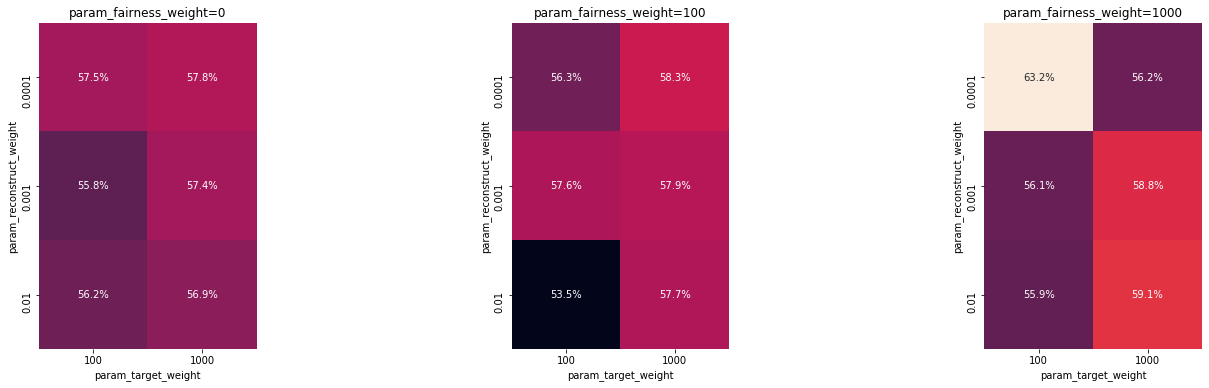

In [ ]:
f, axes = plt.subplots(1, 3, squeeze=True, figsize=(24, 6))
by_fair = res.set_index('param_fairness_weight')
for ax, r in zip(axes, by_fair.index.unique()):
    sns.heatmap(by_fair.xs(r).pivot('param_reconstruct_weight', 'param_target_weight', 'mean_test_score'),
                annot=True, fmt='.1%', vmin=res.mean_test_score.min(), vmax=res.mean_test_score.max(), square=True, cbar=False, ax=ax);
    ax.set_title('param_fairness_weight={}'.format(r))

Compare predictions from naive logistic regression, LFR (in-processing), and LFR (pre-processing) with a logistic regression classifier.

In [ ]:
y_pred_lfr = grid.predict(X_test)
lr = LogisticRegression(solver='lbfgs', random_state=123)
y_pred_lr = lr.fit(X_train, y_train).predict(X_test)
y_pred_lfr_lr = lr.fit(grid.transform(X_train), y_train).predict(X_test)

In [ ]:
# https://matplotlib.org/3.3.0/gallery/lines_bars_and_markers/barchart.html
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        plt.annotate('{:.1%}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

def plot_metrics(y_pred_lr, y_pred_lfr, y_pred_lfr_lr):
    f = plt.figure(figsize=(12, 6))

    preds = [y_pred_lr, y_pred_lfr, y_pred_lfr_lr]
    colors = ['y', 'b', 'm']
    labels = ['LR', 'LFR', 'LFR+LR']
    i = 0
    for y_pred, c, label in zip(preds, colors, labels):
        autolabel(plt.bar([i], [accuracy_score(y_test, y_pred)], color=c, label=label))
        i += 1
    i += 1.5
    for y_pred, c in zip(preds, colors):
        autolabel(plt.bar([i], [balanced_accuracy_score(y_test, y_pred)], color=c))
        i += 1
    i += 1.5
    for y_pred, c in zip(preds, colors):
        autolabel(plt.bar([i], [discrimination(y_test, y_pred)], color=c))
        i += 1
    i += 1.5
    for y_pred, c in zip(preds, colors):
        autolabel(plt.bar([i], [consistency_score(X_test, y_pred)], color=c))
        i += 1

    plt.xlabel('Adult')
    plt.xticks([1, 5.5, 10, 14.5], ['Accuracy', 'Balanced Accuracy', 'Discrimination', 'Consistency'])
    plt.ylim([0, 1.1])
    plt.legend()
    plt.close()
    return f

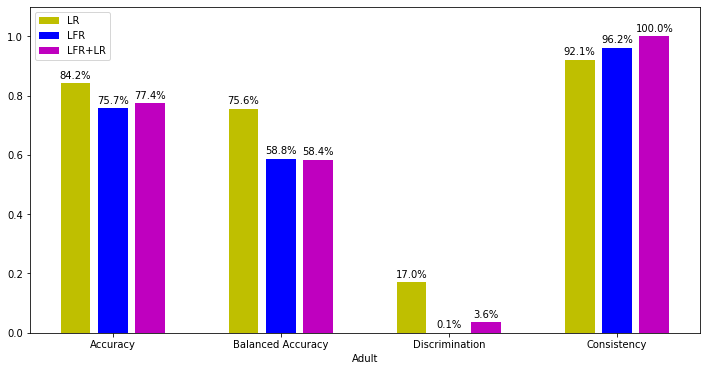

In [ ]:
plot_metrics(y_pred_lr, y_pred_lfr, y_pred_lfr_lr)

Feel free to try this out with other datasets as well!